<a href="https://colab.research.google.com/github/naomiehl/ComputerVision_CleanDirty/blob/main/StochasticVolatility_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import time
import sys
import os
from py_vollib.black_scholes.implied_volatility import implied_volatility as implVola
from scipy.stats import norm
import numpy as np, tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
pip install py_vollib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
class NeuralNetwork(tf.keras.Model):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.LAYERLENGTH = 64
        self.NUMHIDDENLAYERS = 4
        self.l = [tf.keras.layers.Dense(self.LAYERLENGTH,
                                        activation = tf.nn.leaky_relu,
                                        bias_initializer=tf.zeros_initializer(),
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                        use_bias=True) for i in range(self.NUMHIDDENLAYERS)]

        self.l += [tf.keras.layers.Dense(self.LAYERLENGTH,
                                         activation=tf.nn.tanh,
                                         bias_initializer=tf.zeros_initializer(),
                                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05),
                                         use_bias=True)]

        self.l += [tf.keras.layers.Dense(1, activation=None, use_bias=True,
                                         bias_initializer=tf.zeros_initializer(),
                                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.05))]

    def call(self, x):
        for layer in self.l:
            x = layer(x)
        return x

In [71]:
# Feed Forward
class NeuralNetwork(tf.keras.Model):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.l = [tf.keras.layers.Dense(64, activation=tf.nn.tanh)]
        self.l += [tf.keras.layers.Dense(16, activation=tf.nn.tanh)]
        self.l += [tf.keras.layers.Dense(1, activation=tf.nn.tanh)]

    def call(self, x):
        for layer in self.l:
            x = layer(x)
        return x

In [57]:
# RNN

class NeuralNetwork(tf.keras.Model):

    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.l = [tf.keras.layers.Embedding(32,64)]
        self.l += [tf.keras.layers.LSTM(128, activation=tf.nn.tanh)]
        self.l += [tf.keras.layers.Dense(10, activation=tf.nn.tanh)]


    def call(self, x):
        for layer in self.l:
            x = layer(x)
        return x

In [84]:
# Black & Scholes engine

class BlackScholesEngine():
    def callPriceBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        return S*norm.cdf(d1)-norm.cdf(d2)*K*np.exp(-r*T)

    def putPriceBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        return -S*norm.cdf(-d1)+norm.cdf(-d2)*K*np.exp(-r*T)

    def callDeltaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.cdf(d1)

    def putDeltaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return -norm.cdf(-d1)

    def gammaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return norm.pdf(d1)/(S*sigma*np.sqrt(T))

    def vegaBlackScholes(self, S, K, T, r, sigma):
        d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        return S*np.sqrt(T)*norm.pdf(d1)



dist_norm =  tfp.distributions.Normal(loc=0., scale=1.)

def callDeltaBlackScholes(t, x, strike, vola, mat): 
    d1 = tf.math.log(x/strike) + 0.5*tf.square(vola)*(mat-t)
    d1 = d1/(vola*tf.cast(tf.math.sqrt(mat-t), tf.float32))
    return dist_norm.cdf(d1)

def putDeltaBlackScholes(t, x, strike, vola, mat): 
    d1 = tf.math.log(x/strike) + 0.5*tf.square(vola)*(mat-t)
    d1 = d1/(vola*tf.cast(tf.math.sqrt(mat-t), tf.float32))
    return -dist_norm.cdf(-d1)

In [85]:
# Spot
S = 20000
# Volatility
vol = 0.2

# Strike of the Call option
K = 20000
# Horizon
T = 0.1
# Number of time steps
nbSteps = 10

# Risk-free rate
r = 0.0
# Implied volatility
sigma = 0.2

# transaction cost
# example: S=100, Delta=1, the transaction cost equals: omega*S*|Delta|
# omega = 0.003
omega = 0.0

correlSpotVol = -0.75
meanRevert = 2
volOfVol = 1.5

class DeepHedgingEngine(tf.keras.Model):
    def __init__(self, r, sigma, vol, S, K, T, nbSteps, omega, correlSpotVol, meanRevert, volOfVol):
        super(DeepHedgingEngine, self).__init__()

        self.r = r
        self.sigma = sigma
        self.vol = vol
        self.S = S
        self.K = K

        self.T = T
        self.nbSteps = nbSteps
        self.dt = self.T/self.nbSteps
        self.taux = np.linspace(0, self.T, self.nbSteps+1)

        self.priceBS = BlackScholesEngine().callPriceBlackScholes(self.S, self.K, self.T, 0.0, self.sigma)
        self.omega = omega

        self.correlSpotVol = correlSpotVol
        self.meanRevert = meanRevert
        self.volOfVol = volOfVol

        self.nn = [NeuralNetwork() for _ in range(self.nbSteps+1)]

    def call(self, n_paths):
        helperX = tf.reshape(0.0, [1,-1])
        X = tf.tile(helperX, [n_paths,1])
        helperFactor = tf.reshape(0.0, [1,-1])
        factor = tf.tile(helperFactor, [n_paths,1])

        helperStochInt = tf.reshape(0.0, [1,-1])
        stochInt = tf.tile(helperStochInt, [n_paths,1])

        for step in np.arange(self.nbSteps):
            G = tf.random.normal(tf.shape(X), mean=0, stddev=1)
            Z = tf.random.normal(tf.shape(X), mean=0, stddev=1)
            Z = self.correlSpotVol*G + np.sqrt(1 - self.correlSpotVol**2)*Z

            alpha = self.vol*tf.exp(self.volOfVol*factor)
            deltaX = - 0.5*alpha**2*self.dt + alpha*np.sqrt(self.dt)*G

            delta = self.hedgingFunction(step, X)
            stochInt = stochInt + delta*self.S*(tf.exp(X+deltaX)-tf.exp(X))
            hedgingQuantity = delta

            X += deltaX
            factor = factor*np.exp(-self.meanRevert*self.dt) + np.sqrt((1-np.exp(-2*self.meanRevert*self.dt))/(2*self.meanRevert))*Z

        payoff = tf.maximum(self.S*tf.exp(X)-K, 0)
        hedgingError = tf.square(self.priceBS + stochInt - payoff)
        return tf.reduce_mean(hedgingError)

    def PnL(self, n_paths):
        helperX = tf.reshape(0.0, [1,-1])
        X = tf.tile(helperX, [n_paths,1])
        helperFactor = tf.reshape(0.0, [1,-1])
        factor = tf.tile(helperFactor, [n_paths,1])

        helperStochInt = tf.reshape(0.0, [1,-1])
        stochInt = tf.tile(helperStochInt, [n_paths,1])

        for step in np.arange(self.nbSteps):
            G = tf.random.normal(tf.shape(X), mean=0, stddev=1)
            Z = tf.random.normal(tf.shape(X), mean=0, stddev=1)
            Z = self.correlSpotVol*G + np.sqrt(1 - self.correlSpotVol**2)*Z

            alpha = self.vol*tf.exp(self.volOfVol*factor)
            deltaX = - 0.5*alpha**2*self.dt + alpha*np.sqrt(self.dt)*G

            delta = self.hedgingFunction(step, X)
            stochInt = stochInt + delta*self.S*(tf.exp(X+deltaX)-tf.exp(X))
            hedgingQuantity = delta

            X += deltaX
            factor = factor*np.exp(-self.meanRevert*self.dt) + np.sqrt((1-np.exp(-2*self.meanRevert*self.dt))/(2*self.meanRevert))*Z

        payoff = tf.maximum(self.S*tf.exp(X)-K, 0)
        hedgingError = tf.square(self.priceBS + stochInt - payoff)
        return tf.reduce_mean(hedgingError)

    def hedgingFunction(self, mat_index, inputs):
        # deltaBS = callDeltaBlackScholes(self.taux[mat_index], self.S*tf.exp(inputs), self.K, self.sigma, self.T)
        # return deltaBS+self.nn[mat_index](inputs)
        return self.nn[mat_index](inputs)


In [86]:
model = DeepHedgingEngine(r, sigma, vol, S, K, T, nbSteps, omega, correlSpotVol, meanRevert, volOfVol)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

@tf.function(
input_signature=[
    tf.TensorSpec(shape=None, dtype=tf.int32),
],
)
def train_step(n_paths):
    with tf.GradientTape() as tape:
        loss_value = model(n_paths)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value

first_time = model(1)
first_time

<tf.Tensor: shape=(), dtype=float32, numpy=125055.82>

In [87]:
batch_size = tf.constant(400)
maxIter = 100

start_time = time.time()

for k in range(maxIter):
    loss_value = train_step(batch_size)
    print(loss_value)

print("--- loss function: ", np.round(loss_value.numpy(), 6), "    ---")
print("---", time.time() - start_time, "seconds ---")

tf.Tensor(427399.2, shape=(), dtype=float32)
tf.Tensor(536289.25, shape=(), dtype=float32)
tf.Tensor(450521.7, shape=(), dtype=float32)
tf.Tensor(445930.4, shape=(), dtype=float32)
tf.Tensor(458345.0, shape=(), dtype=float32)
tf.Tensor(488908.2, shape=(), dtype=float32)
tf.Tensor(455571.03, shape=(), dtype=float32)
tf.Tensor(526563.25, shape=(), dtype=float32)
tf.Tensor(434218.88, shape=(), dtype=float32)
tf.Tensor(380189.53, shape=(), dtype=float32)
tf.Tensor(352645.9, shape=(), dtype=float32)
tf.Tensor(375299.28, shape=(), dtype=float32)
tf.Tensor(397936.7, shape=(), dtype=float32)
tf.Tensor(296556.94, shape=(), dtype=float32)
tf.Tensor(374310.47, shape=(), dtype=float32)
tf.Tensor(341401.03, shape=(), dtype=float32)
tf.Tensor(303712.4, shape=(), dtype=float32)
tf.Tensor(306466.9, shape=(), dtype=float32)
tf.Tensor(227253.02, shape=(), dtype=float32)
tf.Tensor(214833.23, shape=(), dtype=float32)
tf.Tensor(240426.88, shape=(), dtype=float32)
tf.Tensor(160840.2, shape=(), dtype=float32

In [88]:
start_time = time.time()

Pnl=[]
for i in range(1,100):
  Pnl.append(model(i).numpy())
Pnl

[5674.97,
 9944.662,
 2725.1091,
 75357.0,
 73868.61,
 64574.113,
 37028.43,
 42141.97,
 29643.133,
 142981.58,
 15373.801,
 25976.469,
 34363.246,
 17395.24,
 65717.48,
 43186.266,
 72595.12,
 91586.23,
 51207.72,
 43121.652,
 39877.566,
 150783.61,
 52446.023,
 59995.637,
 49916.094,
 60292.246,
 60626.273,
 34417.32,
 46723.555,
 69604.46,
 31186.76,
 36762.977,
 51029.91,
 40548.023,
 63994.984,
 51049.27,
 67960.305,
 52504.742,
 59210.76,
 36925.727,
 57824.42,
 40768.055,
 55860.582,
 47100.46,
 50487.555,
 90166.375,
 41186.406,
 60097.52,
 55080.973,
 41003.316,
 40542.89,
 55826.703,
 48461.64,
 64658.8,
 60357.21,
 50799.918,
 54960.035,
 38762.574,
 54669.01,
 36225.566,
 34521.383,
 41327.414,
 48323.35,
 35180.508,
 41926.273,
 40658.633,
 49828.953,
 52512.49,
 77761.51,
 86471.51,
 47431.203,
 55803.86,
 90104.445,
 61352.945,
 47929.203,
 64039.348,
 48270.62,
 45478.46,
 43716.516,
 56241.4,
 47747.418,
 64682.49,
 54993.79,
 60980.98,
 51412.7,
 60816.63,
 68607.34,


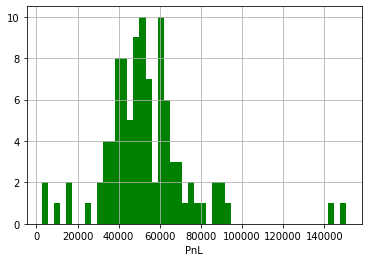

--- 3.902250289916992 seconds ---


In [89]:
PnL = [x for x in Pnl]
plt.hist(PnL, 50, facecolor='g')
plt.xlabel("PnL")
plt.grid(zorder=10)
plt.show()
print("---", time.time() - start_time, "seconds ---")

In [90]:
roun = 2

print("PnL statistics")
print("mean:", np.round(np.mean(Pnl), roun))
print("std:", np.round(np.std(Pnl), roun))
print("VaR99", np.round(np.quantile(Pnl, .99), roun))
print("VaR95", np.round(np.quantile(Pnl, .95), roun))
print("VaR90", np.round(np.quantile(Pnl, .90), roun))
print("VaR80", np.round(np.quantile(Pnl, .80), roun))
print("VaR50", np.round(np.quantile(Pnl, .50), roun))
print("5th-percentile:", np.round(np.percentile(Pnl, 5), roun))
print("95th-percentile:", np.round(np.percentile(Pnl, 95), roun))

PnL statistics
mean: 53411.36
std: 21448.86
VaR99 143137.62
VaR95 86834.8
VaR90 74166.29
VaR80 64607.99
VaR50 51029.91
5th-percentile: 25118.35
95th-percentile: 86834.8


In [91]:
'''
import torch
import torchvision

def entropic_loss(Pnl):
    Pnl = torch.tensor(Pnl)
    return  np.round(-np.mean(-np.exp(-Pnl)).roun)
print("Entropic Loss Measure (ERM):", entropic_loss(Pnl))'''

'\nimport torch\nimport torchvision\n\ndef entropic_loss(Pnl):\n    Pnl = torch.tensor(Pnl)\n    return  np.round(-np.mean(-np.exp(-Pnl)).roun)\nprint("Entropic Loss Measure (ERM):", entropic_loss(Pnl))'

In [92]:
model.nbSteps

10

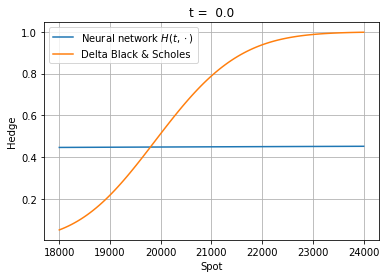

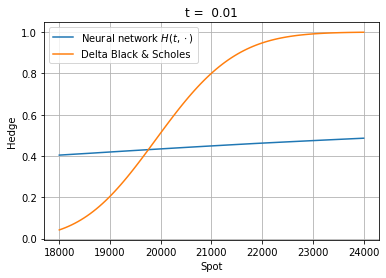

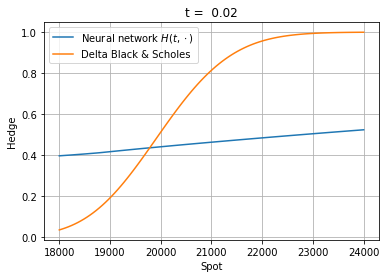

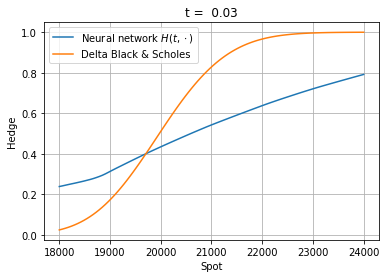

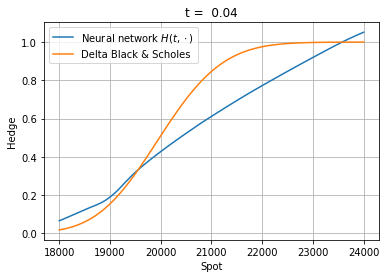

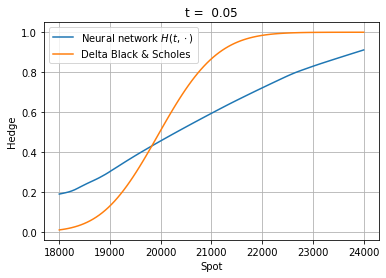

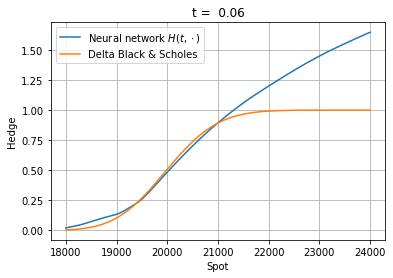

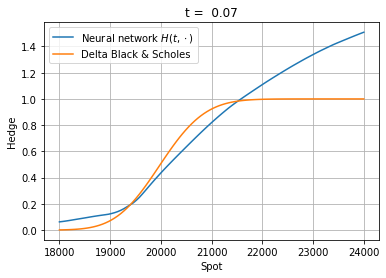

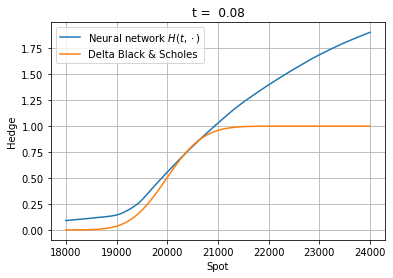

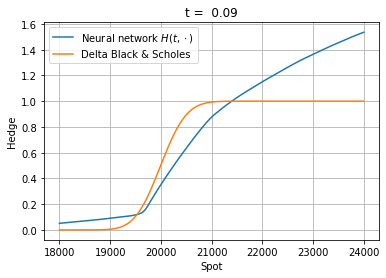

In [93]:
arraySpot = np.linspace(0.9*model.S, 1.2*model.S, 100)
arraySpot = arraySpot.astype(np.float32)
arraySpot = np.reshape(arraySpot, [-1,1])

for i in range(model.nbSteps):
    plt.plot(arraySpot, model.hedgingFunction(i, np.log(arraySpot/model.S)), label="Neural network $H(t, \cdot)$")
    plt.plot(arraySpot, BlackScholesEngine().callDeltaBlackScholes(arraySpot, model.K, model.T-model.taux[i], 0.0, model.sigma), label="Delta Black & Scholes")
    plt.title("t =  {}".format(np.round(model.taux[i], 4)))
    plt.xlabel("Spot")
    plt.ylabel("Hedge")
    plt.legend()
    plt.grid()
    plt.show()

In [94]:
model.summary()

Model: "deep_hedging_engine_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 neural_network_68 (NeuralNe  multiple                 16833     
 twork)                                                          
                                                                 
 neural_network_69 (NeuralNe  multiple                 16833     
 twork)                                                          
                                                                 
 neural_network_70 (NeuralNe  multiple                 16833     
 twork)                                                          
                                                                 
 neural_network_71 (NeuralNe  multiple                 16833     
 twork)                                                          
                                                                 
 neural_network_72 (NeuralNe  multiple       